In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [3]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

In [4]:
df_nisk = pd.read_csv('../Dissertation_projects/Data/CTD/NISK_SUMS.csv', sep=',', index_col=0)

# drop rows with NaN index values
df_nisk = df_nisk[df_nisk['Sample_ID'].notna()]
df_nisk['code'] = df_nisk['station'] + '_' + df_nisk['camp']

# reformat the index to be a whole number
df_nisk.index = df_nisk.index.astype(int)

In [5]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [6]:
df_c = pd.read_csv('../Dissertation_projects/Data/CDOM/Outputs.csv', sep=',', index_col=0)

df_c['Sample_idx'] = df_c.index.astype(object)
df_meta['Sample_idx'] = df_meta.index.astype(object)

df_c.index = df_c['file_id']

df_cdom = df_c.merge(df_meta, on="Sample_idx", how="left")

df_cdom.index = df_cdom['Sample_idx']
df_cdom['Sample'] = df_cdom.index
df_cdom.index = df_cdom['Sample']
df_cdom = df_cdom.drop('Sample_idx', axis = 1)
df_meta = df_meta.drop('Sample_idx', axis = 1)

df_cdom['Sample_depth'] = pd.to_numeric(df_cdom['Sample_depth'], errors='coerce')


In [7]:
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']
df_por

,porosity,depth,camp,Stn,code
0,0.896846,0.25,GOM2021,St.11,St.11_GOM2021
1,0.898594,0.75,GOM2021,St.11,St.11_GOM2021
2,0.887348,1.25,GOM2021,St.11,St.11_GOM2021
3,0.879845,1.75,GOM2021,St.11,St.11_GOM2021
4,0.869916,2.50,GOM2021,St.11,St.11_GOM2021
...,...,...,...,...,...
1061,0.660463,17.00,GOM22SU,St.MK,St.MK_GOM22SU
1062,0.696337,19.00,GOM22SU,St.MK,St.MK_GOM22SU
1063,0.704780,22.50,GOM22SU,St.MK,St.MK_GOM22SU
1064,0.600938,27.50,GOM22SU,St.MK,St.MK_GOM22SU


In [8]:
#get BC data sets 
df_cdom_bc = df_cdom[df_cdom['Type'] == 'LANDSYR']
df_iron_bc = df_iron[df_iron['Type'] == 'BC']
df_doc_bc = df_doc[df_doc['Type'] == 'BC']

#get PW data sets 
df_cdom_pw = df_cdom[df_cdom['Type'] == 'PW']
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

#get WC data sets 
df_cdom_wc = df_cdom[df_cdom['Type'] == 'NISK']
df_iron_wc = df_iron[df_iron['Type'] == 'WC']
df_doc_wc = df_doc[df_doc['Type'] == 'WC']

#get RHZ data 
df_cdom_rz = df_cdom[df_cdom['Type'] == 'RHZ']
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ', 'GBRZ'])]
df_doc_rz = df_doc[df_doc['Type'] == 'RZ']

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9960\319912137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cdom_pw['Sample_idx'] = df_cdom_pw.index.astype(object)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9960\319912137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_doc_pw['Sample_idx'] = df_doc_pw.index.astype(object)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_9960\319912137.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

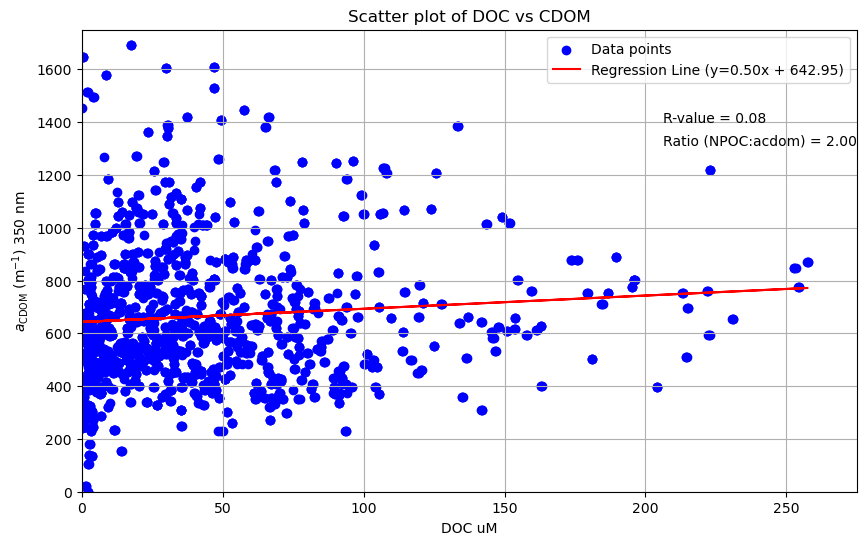

0.12360631301225901

In [9]:
df_cdom_pw['Sample_idx'] = df_cdom_pw.index.astype(object)
df_doc_pw['Sample_idx'] = df_doc_pw.index.astype(object)

df_cdom_pw.index = df_cdom_pw['file_id']

df_cdom_doc = df_cdom_pw.merge(df_doc_pw, on="Sample_idx", how="left")

df_cdom_doc.index = df_cdom_doc['Sample_idx']
df_cdom_doc['Sample'] = df_cdom_doc.index
df_cdom_doc.index = df_cdom_doc['Sample']

df_cdom_pw.index = df_cdom_pw['Sample_idx']
df_cdom_pw['Sample'] = df_cdom_pw.index
df_cdom_pw.index = df_cdom_pw['Sample']

df_doc_pw.index = df_doc_pw['Sample_idx']
df_doc_pw['Sample'] = df_doc_pw.index
df_doc_pw.index = df_doc_pw['Sample']

df_cdom_doc = df_cdom_doc.drop('Sample_idx', axis = 1)
df_doc_pw = df_doc_pw.drop('Sample_idx', axis = 1)
df_cdom_pw = df_cdom_pw.drop('Sample_idx', axis = 1)

# Step 2: Conducting a linear regression
df_cdom_doc = df_cdom_doc.dropna(subset=['NPOC_uM', 'acdom_350_bc'])
df_cdom_doc = df_cdom_doc[df_cdom_doc['NPOC_uM'] <= 2000]

slope, intercept, r_value, p_value, std_err = stats.linregress(df_cdom_doc['acdom_350_bc'], df_cdom_doc['NPOC_uM'])

# Step 3: Finding the ratio where NPOC_uM is equal to acdom_350_pw
x_equal = 1 / (slope)
x_err = std_err

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_cdom_doc['acdom_350_bc'], df_cdom_doc['NPOC_uM'], color='blue', label='Data points')
x_vals = df_cdom_doc['acdom_350_bc']
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='red', label=f'Regression Line (y={slope:.2f}x + {intercept:.2f})')

plt.xlim(0,275)
plt.ylim(0,1750)

# Annotating the plot
plt.annotate(f'Ratio (NPOC:acdom) = {x_equal:.2f}', xy=(0.75, 0.75), xycoords='axes fraction')
plt.annotate(f'R-value = {r_value:.2f}', xy=(0.75, 0.80), xycoords='axes fraction')

plt.ylabel(r'$a_{\mathrm{CDOM}}$ (m$^{-1}$) 350 nm')
plt.xlabel('DOC uM')
plt.legend()
plt.title('Scatter plot of DOC vs CDOM')
plt.grid(True)
plt.show()

x_err

In [10]:
#D coeff 
D = .00001728

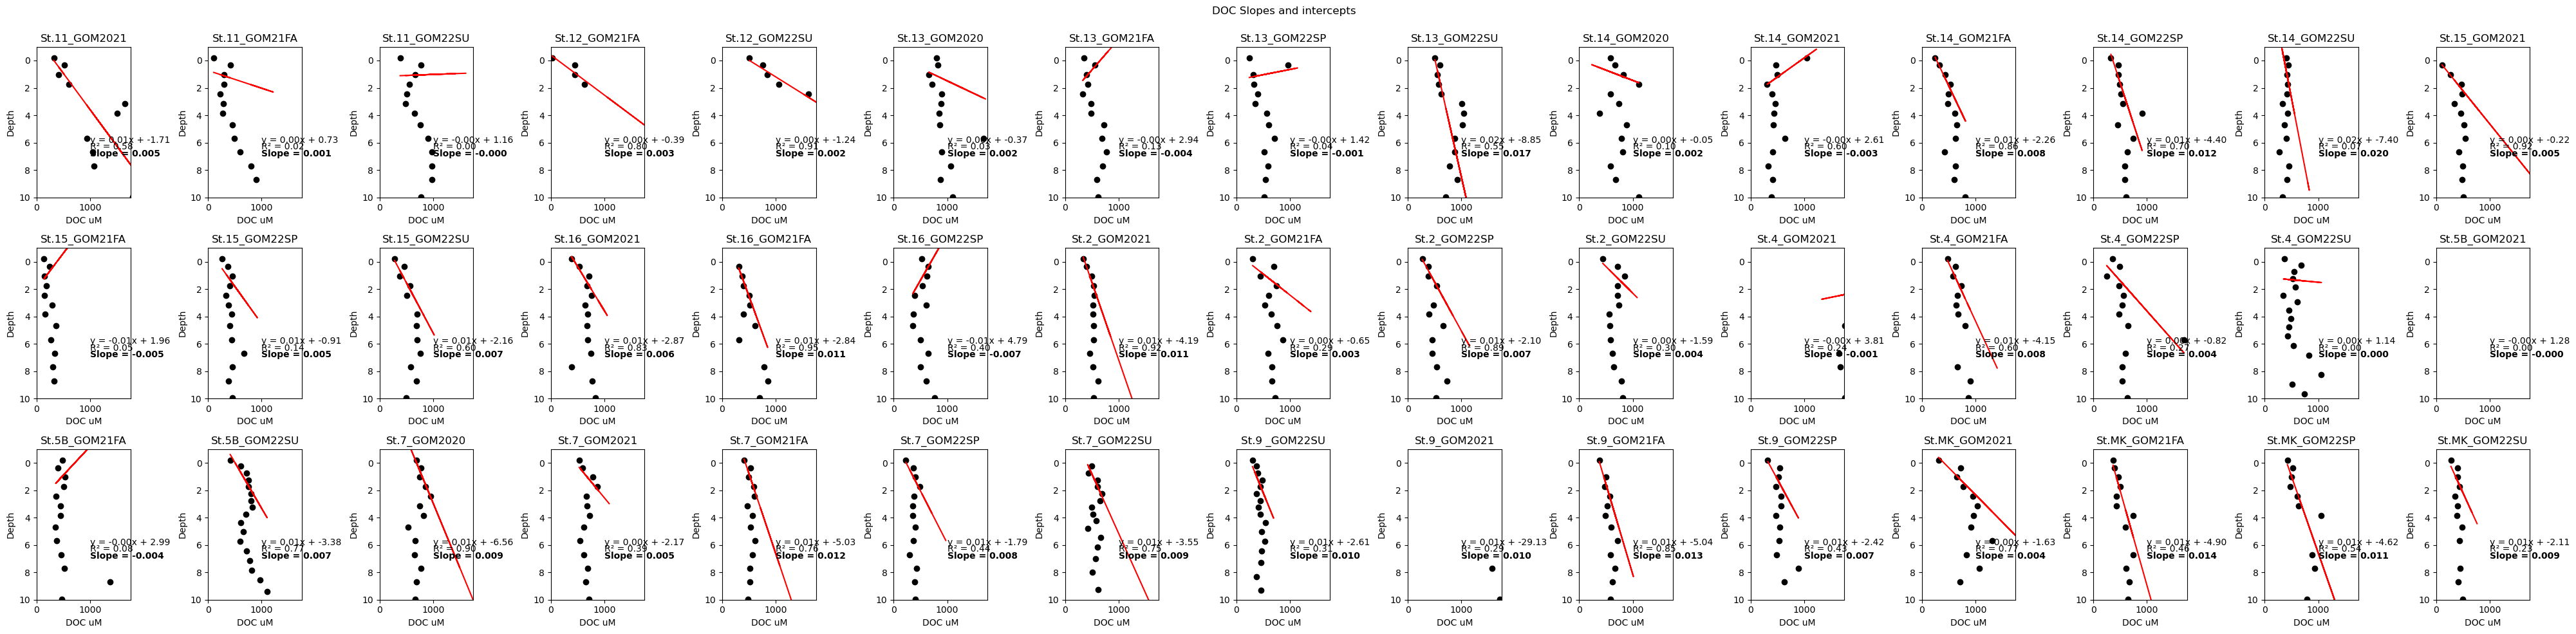

In [11]:
#DOC slopes 
df_doc_pw_plot = df_doc_pw[(df_doc_pw['NPOC_uM'] != 0)]
df_doc_pw_plot = df_doc_pw_plot.dropna(subset=["NPOC_uM"])
codes = df_doc_pw_plot['code'].unique()

#make plot
fig, axs = plt.subplots(nrows=3, ncols=15, figsize=(40, 10)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_doc_pw_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    y = group['Depth']
    x = group['NPOC_uM']
        
    yy = group.loc[group['Depth'] < 3, 'Depth'].ravel()
    xx = group.loc[group['Depth'] < 3, 'NPOC_uM'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 15, i % 15]
    sc = ax.scatter(x, y, c = 'black')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_ylabel('Depth')
    ax.set_xlabel(r'DOC uM')
    ax.set_ylim(10,-1)
    ax.set_xlim(0,1750)
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='r')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(1000, 6, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(1000, 6.5, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(1000, 7, sloped, fontweight='bold')
    

# Add overall figure labels and color bar
fig.suptitle(r'DOC Slopes and intercepts' '\n')
plt.tight_layout()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/DOC_PW_flux.png")

plt.show()


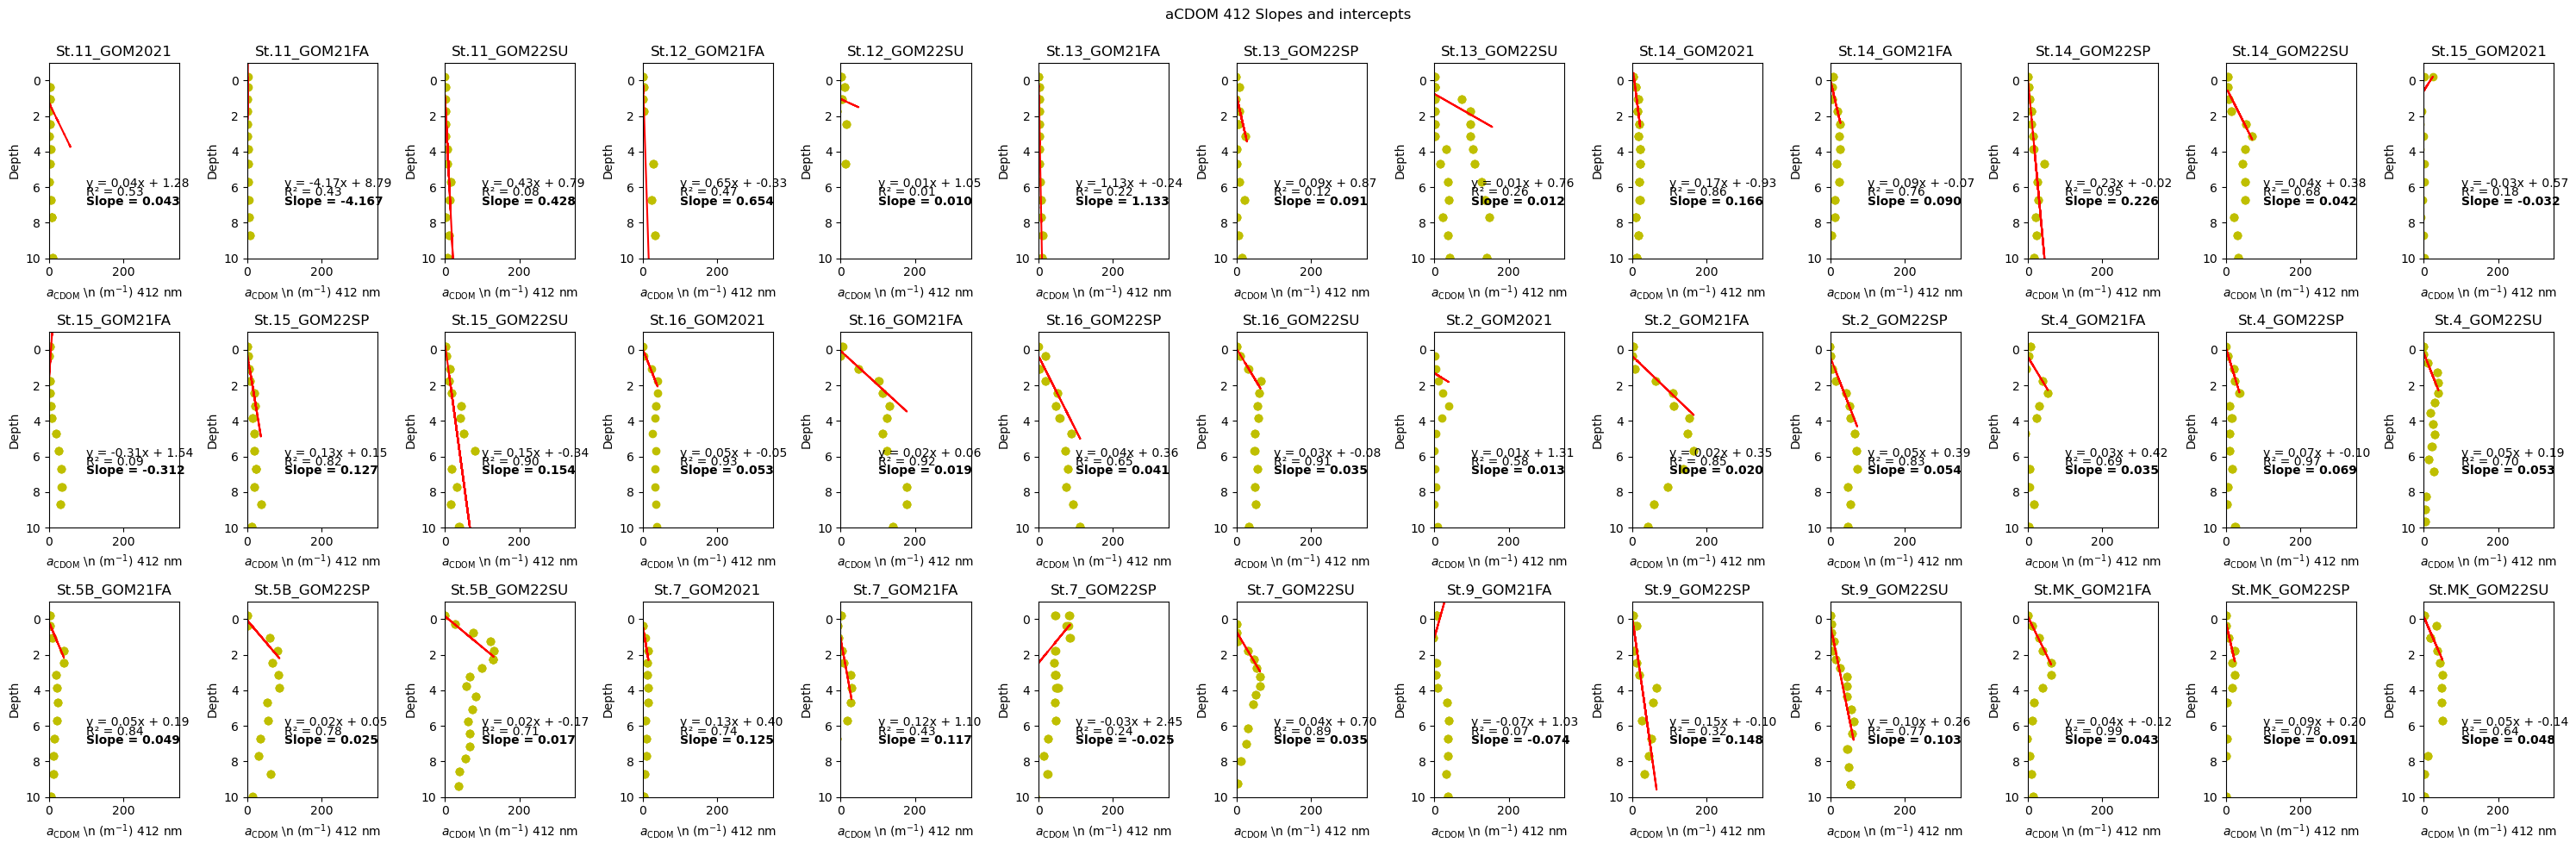

In [12]:
#CDOM slopes 
df_cdom_pw_plot = df_cdom_pw.dropna(subset=["acdom_412_bc"])
df_cdom_pw_plot = df_cdom_pw_plot[(df_cdom_pw_plot['Sample_depth'] > -10)]

codes = df_cdom_pw_plot['code'].unique()

#make plot
fig, axs = plt.subplots(nrows=3, ncols=13, figsize=(30, 10)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_cdom_pw_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    y = group['Sample_depth']
    x = group['acdom_412_bc']
    
    yy = group.loc[group['Sample_depth'] < 3, 'Sample_depth'].ravel()
    xx = group.loc[group['Sample_depth'] < 3, 'acdom_412_bc'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 13, i % 13]
    sc = ax.scatter(x, y, c='y')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_ylabel('Depth')
    ax.set_xlabel(r'$a_{\mathrm{CDOM}}$ \n (m$^{-1}$) 412 nm')
    ax.set_ylim(10,-1)
    ax.set_xlim(0,350)
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='r')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(100, 6, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(100, 6.5, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(100, 7, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'aCDOM 412 Slopes and intercepts' '\n')
plt.tight_layout()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/aCDOM412_PW_flux.png")

plt.show()


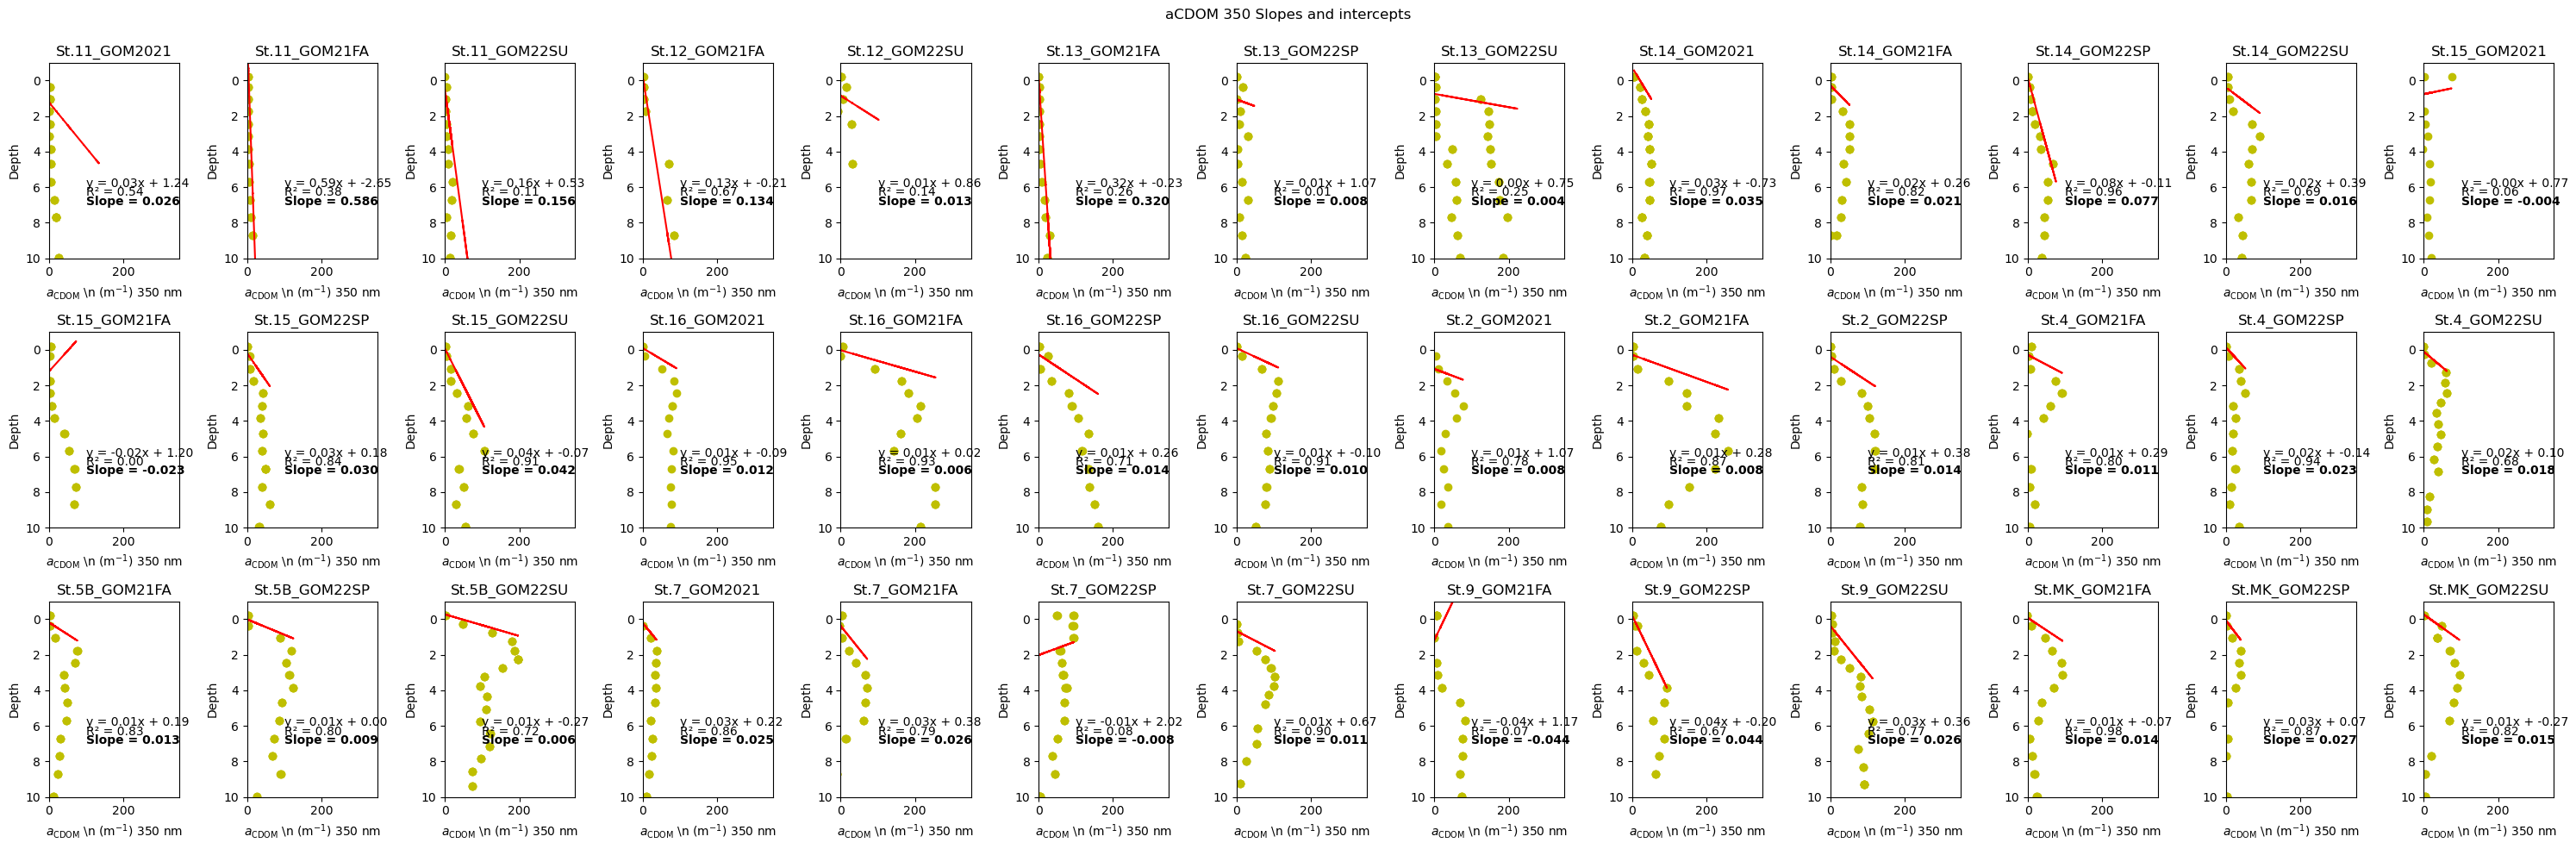

In [13]:
#CDOM slopes 
df_cdom_pw_plot = df_cdom_pw.dropna(subset=["acdom_350_bc"])
df_cdom_pw_plot = df_cdom_pw_plot[(df_cdom_pw_plot['Sample_depth'] > -10)]

codes = df_cdom_pw_plot['code'].unique()

#make plot
fig, axs = plt.subplots(nrows=3, ncols=13, figsize=(30, 10)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_cdom_pw_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    y = group['Sample_depth']
    x = group['acdom_350_bc']
    
    yy = group.loc[group['Sample_depth'] < 3, 'Sample_depth'].ravel()
    xx = group.loc[group['Sample_depth'] < 3, 'acdom_350_bc'].ravel() * x_equal
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 13, i % 13]
    sc = ax.scatter(x, y, c='y')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_ylabel('Depth')
    ax.set_xlabel(r'$a_{\mathrm{CDOM}}$ \n (m$^{-1}$) 350 nm')
    ax.set_ylim(10,-1)
    ax.set_xlim(0,350)
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='r')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(100, 6, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(100, 6.5, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(100, 7, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'aCDOM 350 Slopes and intercepts' '\n')
plt.tight_layout()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/aCDOM350_PW_flux.png")

plt.show()


In [14]:
#DOC slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_doc_pw_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group.loc[group['Depth'] < 3, 'Depth'].ravel() / 1000
    y = group.loc[group['Depth'] < 3, 'NPOC_uM'].ravel()
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
    rsquared = r_value**2
    
    # Add the slope value to the plot
    slope = slope
    
    dic = {'code':[code],
           'slope_doc':[slope],
           'err_doc':[std_err],
           'rsquared_doc':[rsquared]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_doc = pd.concat(Frames, axis=0, ignore_index=False)
slopes_doc

,slope_doc,err_doc,rsquared_doc
code,,,
St.11_GOM2021,108297.269823,65786.174801,0.575370
St.11_GOM21FA,14593.989291,60797.862094,0.018845
St.11_GOM22SU,-2871.554024,81413.512620,0.000415
St.12_GOM21FA,272675.819089,97304.816411,0.797012
St.12_GOM22SU,373058.859493,67229.097806,0.911222
St.13_GOM2020,15015.979324,51259.754158,0.027809
St.13_GOM21FA,-29524.510894,43625.144936,0.132453
St.13_GOM22SP,-58307.434159,155178.722545,0.044946
St.13_GOM22SU,31771.759671,16558.447885,0.551010


In [15]:
#CDOM slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_cdom_pw_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group.loc[group['Sample_depth'] < 3, 'Sample_depth'].ravel() / 1000
    y = group.loc[group['Sample_depth'] < 3, 'acdom_412_bc'].ravel()
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
    rsquared = r_value**2
    
    # Add the slope value to the plot
    slope = slope
    
    dic = {'code':[code],
            'slope_a412':[slope],
                      'err_412':[std_err],

            'rsquared_a412':[rsquared]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_a412 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_a412

,slope_a412,err_412,rsquared_a412
code,,,
St.11_GOM2021,12429.104893,2821.858408,0.532971
St.11_GOM21FA,-103.107559,32.947522,0.429661
St.11_GOM22SU,191.494246,193.249552,0.081950
St.12_GOM21FA,718.317742,241.241096,0.469948
St.12_GOM22SU,807.998848,2543.331616,0.007704
St.13_GOM21FA,191.254498,100.832637,0.216757
St.13_GOM22SP,1274.881914,939.011869,0.116346
St.13_GOM22SU,21536.864418,6919.365546,0.257057
St.14_GOM2021,5202.287683,432.322218,0.862933


In [16]:
#CDOM slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_cdom_pw_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group.loc[group['Sample_depth'] < 3, 'Sample_depth'].ravel() / 1000
    y = group.loc[group['Sample_depth'] < 3, 'acdom_350_bc'].ravel()
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
    rsquared = r_value**2
    
    # Add the slope value to the plot
    slope = slope
    
    dic = {'code':[code],
            'slope_a350':[slope],
            'err_350':[std_err],
            'rsquared_a350':[rsquared]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_a350 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_a350

,slope_a350,err_350,rsquared_a350
code,,,
St.11_GOM2021,10520.533869,2366.894206,0.537501
St.11_GOM21FA,321.583148,114.665966,0.376957
St.11_GOM22SU,349.712482,301.012182,0.109294
St.12_GOM21FA,2496.499030,557.062114,0.667600
St.12_GOM22SU,5182.332974,3600.581653,0.137450
St.13_GOM21FA,400.364371,189.082320,0.256438
St.13_GOM22SP,550.147469,1603.919828,0.008334
St.13_GOM22SU,33009.871283,10905.614548,0.246541
St.14_GOM2021,13965.726274,532.045823,0.967697


In [17]:
#make location data 
df_lat_lon = df_meta.groupby('code').agg({'Lat': 'mean', 'Lon': 'mean'}).reset_index().set_index('code')
df_lat_lon

,Lat,Lon
code,,
St.11_GOM2021,28.225724,-89.540904
St.11_GOM21FA,28.209529,-89.591672
St.11_GOM22SU,28.202880,-89.581503
St.12_GOM21FA,28.594249,-88.903741
St.12_GOM22SU,28.593063,-88.878258
St.13_GOM2021,28.536039,-89.492085
St.13_GOM21FA,28.524193,-89.610854
St.13_GOM22SP,28.507026,-89.622720
St.13_GOM22SU,28.524547,-89.597871


In [18]:
# Assuming you already have df_por defined

df_p = df_por.loc[df_por['depth'] < 3]

# Compute aggregated statistics including count for porosity to calculate SE later
df_p = df_p.groupby('code').agg({
    'porosity': ['mean', 'std', 'count'],
    'Stn': 'first',
    'camp': 'first'
}).reset_index()

# Compute Standard Error for porosity
df_p['por_SE'] = df_p['porosity']['std'] / df_p['porosity']['count'].pow(0.5)

# Rename columns for clarity and set the index
df_p.columns = ['code', 'por_mean', 'por_sd', 'por_count', 'Stn', 'camp', 'por_SE']
df_p = df_p.set_index('code')

df_p

,por_mean,por_sd,por_count,Stn,camp,por_SE
code,,,,,,
St.11_GOM2021,0.886510,0.011972,5,St.11,GOM2021,0.005354
St.11_GOM21FA,0.901163,0.014873,6,St.11,GOM21FA,0.006072
St.11_GOM22SU,0.903834,0.010203,6,St.11,GOM22SU,0.004165
St.12_GOM21FA,0.822524,0.021835,6,St.12,GOM21FA,0.008914
St.12_GOM22SU,0.821506,0.039053,6,St.12,GOM22SU,0.015943
St.13_GOM21FA,0.904496,0.006950,6,St.13,GOM21FA,0.002838
St.13_GOM22SU,0.872732,0.023774,3,St.13,GOM22SU,0.013726
St.14_GOM2021,0.844243,0.023660,5,St.14,GOM2021,0.010581
St.14_GOM21FA,0.826907,0.033050,6,St.14,GOM21FA,0.013492


In [19]:
dataframes = [df_por, df_lat_lon, slopes_a412, slopes_a350, slopes_doc]
for df in dataframes:
    if not df.index.is_unique:
        print("Duplicate indices found in dataframe:", df)

In [20]:
#concat it all 
df_flux = pd.concat([df_p, df_lat_lon, slopes_a412, slopes_a350, slopes_doc], axis=1, join='outer')

H = 3
A = np.pi*(4.2388**2) 
D = 0.000001728 

#calcute flux 
df_flux["flux_aCDOM412"] = df_flux["slope_a412"]*x_equal * (H * A * df_flux["por_mean"] / 1000) * D 
df_flux["flux_aCDOM350"] = df_flux["slope_a350"]*x_equal * (H * A * df_flux["por_mean"] / 1000) * D  
df_flux["flux_doc"] = df_flux["slope_doc"] * (H * A * df_flux["por_mean"] / 1000) * D * 1000


df_flux["erros_aCDOM412"] = np.sqrt( ((df_flux["err_412"] / df_flux["slope_a412"])**2) + (((df_flux["por_SE"] / df_flux["por_mean"])**2)/1000) )# +((x_err / x_equal)**2) )
df_flux["erros_aCDOM350"] = np.sqrt( ((df_flux["err_350"] / df_flux["slope_a350"])**2) + (((df_flux["por_SE"] / df_flux["por_mean"])**2)/1000) )# +((x_err / x_equal)**2) )
df_flux["erros_doc"] = np.sqrt( (df_flux["err_doc"] / df_flux["slope_doc"])**2 + (df_flux["por_SE"] / df_flux["por_mean"])**2 )

#df_flux["flux_tn"] = df_flux["slope_tn"] * df_flux["Hight_m"] *24
#df_flux["flux_fe2"] = df_flux["slope_fe2"] * df_flux["Hight_m"] *24
#df_flux["flux_fe3"] = df_flux["slope_fe3"] * df_flux["Hight_m"] *24

df_flux

,por_mean,por_sd,por_count,Stn,camp,por_SE,Lat,Lon,slope_a412,err_412,...,rsquared_a350,slope_doc,err_doc,rsquared_doc,flux_aCDOM412,flux_aCDOM350,flux_doc,erros_aCDOM412,erros_aCDOM350,erros_doc
code,,,,,,,,,,,,,,,,,,,,,
St.11_GOM2021,0.886510,0.011972,5.0,St.11,GOM2021,0.005354,28.225724,-89.540904,12429.104893,2821.858408,...,0.537501,108297.269823,65786.174801,0.575370,0.006444,0.005455,28.093233,0.227036,0.224979,0.607489
St.11_GOM21FA,0.901163,0.014873,6.0,St.11,GOM21FA,0.006072,28.209529,-89.591672,-103.107559,32.947522,...,0.376957,14593.989291,60797.862094,0.018845,-0.000054,0.000169,3.848380,0.319545,0.356567,4.165958
St.11_GOM22SU,0.903834,0.010203,6.0,St.11,GOM22SU,0.004165,28.202880,-89.581503,191.494246,193.249552,...,0.109294,-2871.554024,81413.512620,0.000415,0.000101,0.000185,-0.759462,1.009166,0.860742,28.351726
St.12_GOM21FA,0.822524,0.021835,6.0,St.12,GOM21FA,0.008914,28.594249,-88.903741,718.317742,241.241096,...,0.667600,272675.819089,97304.816411,0.797012,0.000346,0.001201,65.629036,0.335842,0.223138,0.357016
St.12_GOM22SU,0.821506,0.039053,6.0,St.12,GOM22SU,0.015943,28.593063,-88.878258,807.998848,2543.331616,...,0.137450,373058.859493,67229.097806,0.911222,0.000388,0.002490,89.678546,3.147692,0.694780,0.181252
St.13_GOM21FA,0.904496,0.006950,6.0,St.13,GOM21FA,0.002838,28.524193,-89.610854,191.254498,100.832637,...,0.256438,-29524.510894,43625.144936,0.132453,0.000101,0.000212,-7.814297,0.527217,0.472276,1.477594
St.13_GOM22SU,0.872732,0.023774,3.0,St.13,GOM22SU,0.013726,28.524547,-89.597871,21536.864418,6919.365546,...,0.246541,31771.759671,16558.447885,0.551010,0.010993,0.016849,8.113775,0.321280,0.330375,0.521406
St.14_GOM2021,0.844243,0.023660,5.0,St.14,GOM2021,0.010581,28.726863,-89.601437,5202.287683,432.322218,...,0.967697,-213217.985656,101507.345558,0.595261,0.002569,0.006896,-52.673453,0.083103,0.038099,0.476238
St.14_GOM21FA,0.826907,0.033050,6.0,St.14,GOM21FA,0.013492,28.727625,-89.620568,8426.000119,1321.901713,...,0.817512,104650.955980,24321.743391,0.860555,0.004075,0.009243,25.322146,0.156885,0.131039,0.232980


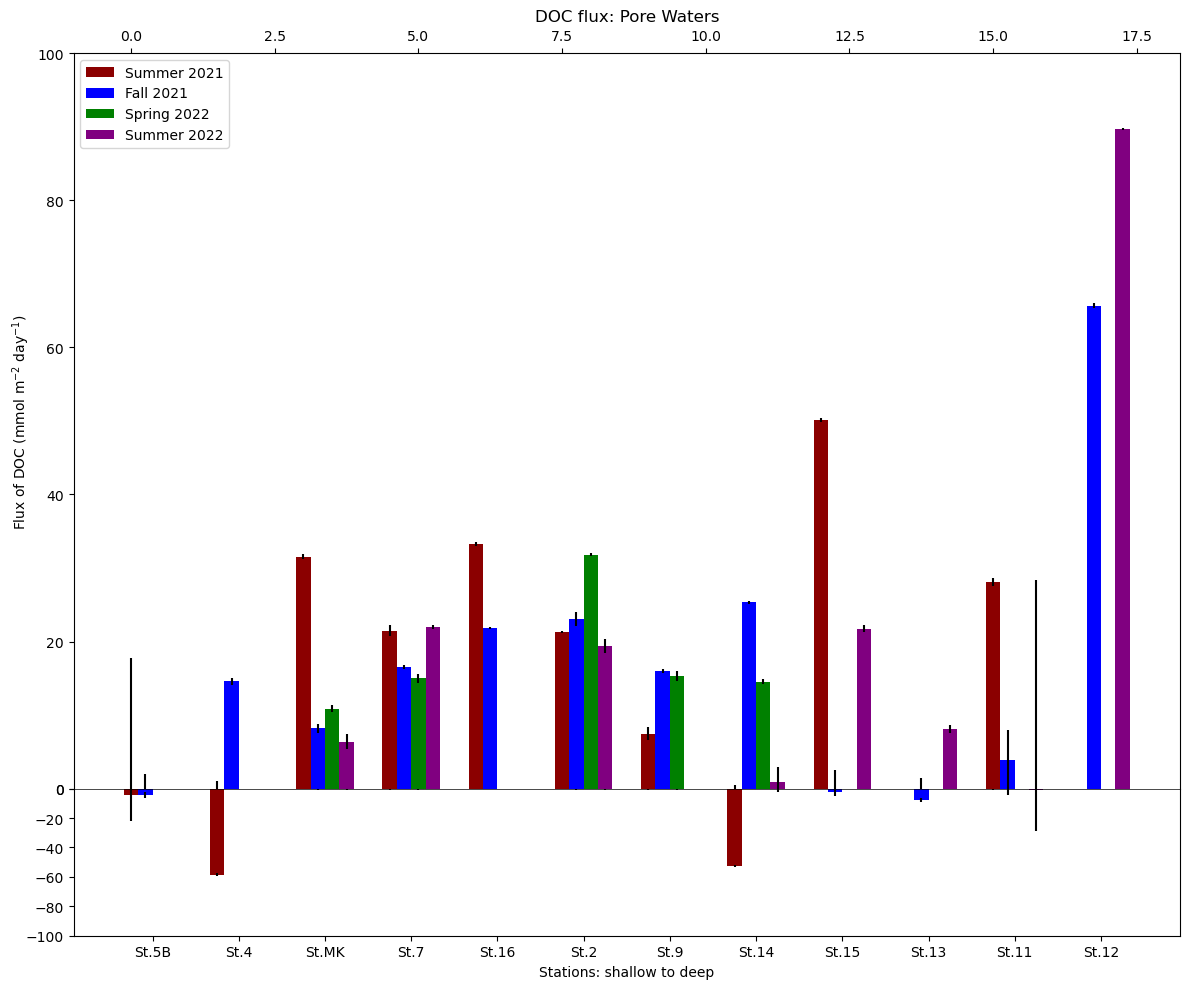

In [21]:
# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_doc"])

categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

# Create figure with custom size
fig = plt.figure(figsize=(12, 10))
# Adjust the height ratios for the subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0)  # Set hspace to 0

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# Adjusted r for spacing between groups
r = np.arange(0, len(categories) * 1.5, 1.5)
positions = [r + i*barWidth for i in range(len(subcategories))]

# Adjusted code for broken axis and added spaces between the groups
for pos, subcat in zip(positions, subcategories):
    values = []
    errors = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['camp'] == subcat)]['flux_doc'].values
        error = df[(df['Stn'] == cat) & (df['camp'] == subcat)]['erros_doc'].values
        values.append(value[0] if len(value) > 0 else 0)
        errors.append(error[0] if len(error) > 0 else 0)
    
    ax1.bar(pos, [v if v > 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat], yerr=[e if e > 0 else 0 for e in errors])
    ax2.bar(pos, [v if v < 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat], yerr=[e if e > 0 else 0 for e in errors])

# Setting the limit for the break
ax1.set_ylim(0, 100)  
ax2.set_ylim(-100, 0)

# Removing spines and ticks for the broken axis effect
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

# Add some text for labels, title, and custom x-axis tick labels
ax2.set_xlabel('Stations: shallow to deep')
ax1.set_ylabel(r'Flux of DOC (mmol m$^{-2}$ day$^{-1}$)')
ax1.set_title('DOC flux: Pore Waters')
ax2.set_xticks(r + 1.5*barWidth)  # Adjust for the spaces between groups
ax2.set_xticklabels(categories)

# Add black horizontal line at y=0
ax1.axhline(0, color="black", linewidth=0.5)
ax2.axhline(0, color="black", linewidth=0.5)

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
ax1.legend(handles[:len(subcategories)], labels)

fig.set_facecolor('w')
plt.tight_layout()

plt.savefig("../Dissertation_projects/Figures/Flux_figures/DOC_PW_flux_barplot.png")

plt.show()

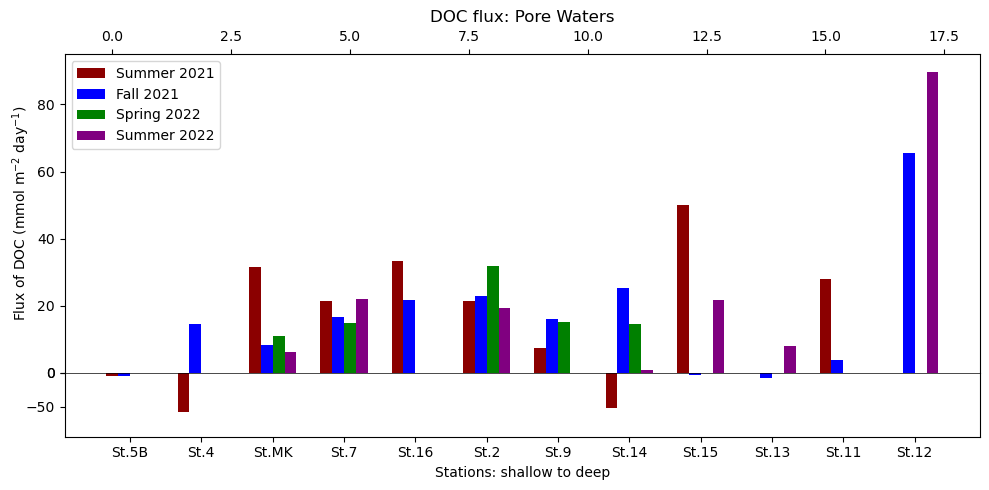

In [22]:
# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_doc"])

categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

# Create figure with custom size
fig = plt.figure(figsize=(10, 5))
# Adjust the height ratios for the subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0)  # Set hspace to 0

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# Adjusted r for spacing between groups
r = np.arange(0, len(categories) * 1.5, 1.5)
positions = [r + i*barWidth for i in range(len(subcategories))]

# Adjusted code for broken axis and added spaces between the groups
for pos, subcat in zip(positions, subcategories):
    values = []
    errors = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['camp'] == subcat)]['flux_doc'].values
        error = df[(df['Stn'] == cat) & (df['camp'] == subcat)]['erros_doc'].values
        values.append(value[0] if len(value) > 0 else 0)
        errors.append(error[0] if len(error) > 0 else 0)
    
    ax1.bar(pos, [v if v > 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat]) #yerr=[e if e > 0 else 0 for e in errors])
    ax2.bar(pos, [v if v < 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat]) #yerr=[e if e > 0 else 0 for e in errors])

# Setting the limit for the break
ax1.set_ylim(0, 95)  
ax2.set_ylim(-95, 0)

# Removing spines and ticks for the broken axis effect
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

# Add some text for labels, title, and custom x-axis tick labels
ax2.set_xlabel('Stations: shallow to deep')
ax1.set_ylabel(r'Flux of DOC (mmol m$^{-2}$ day$^{-1}$)')
ax1.set_title('DOC flux: Pore Waters')
ax2.set_xticks(r + 1.5*barWidth)  # Adjust for the spaces between groups
ax2.set_xticklabels(categories)

# Add black horizontal line at y=0
ax1.axhline(0, color="black", linewidth=0.5)
ax2.axhline(0, color="black", linewidth=0.5)

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
ax1.legend(handles[:len(subcategories)], labels)

fig.set_facecolor('w')
plt.tight_layout()

plt.savefig("../Dissertation_projects/Figures/Flux_figures/_DOC_PW_flux_barplot.png")

plt.show()

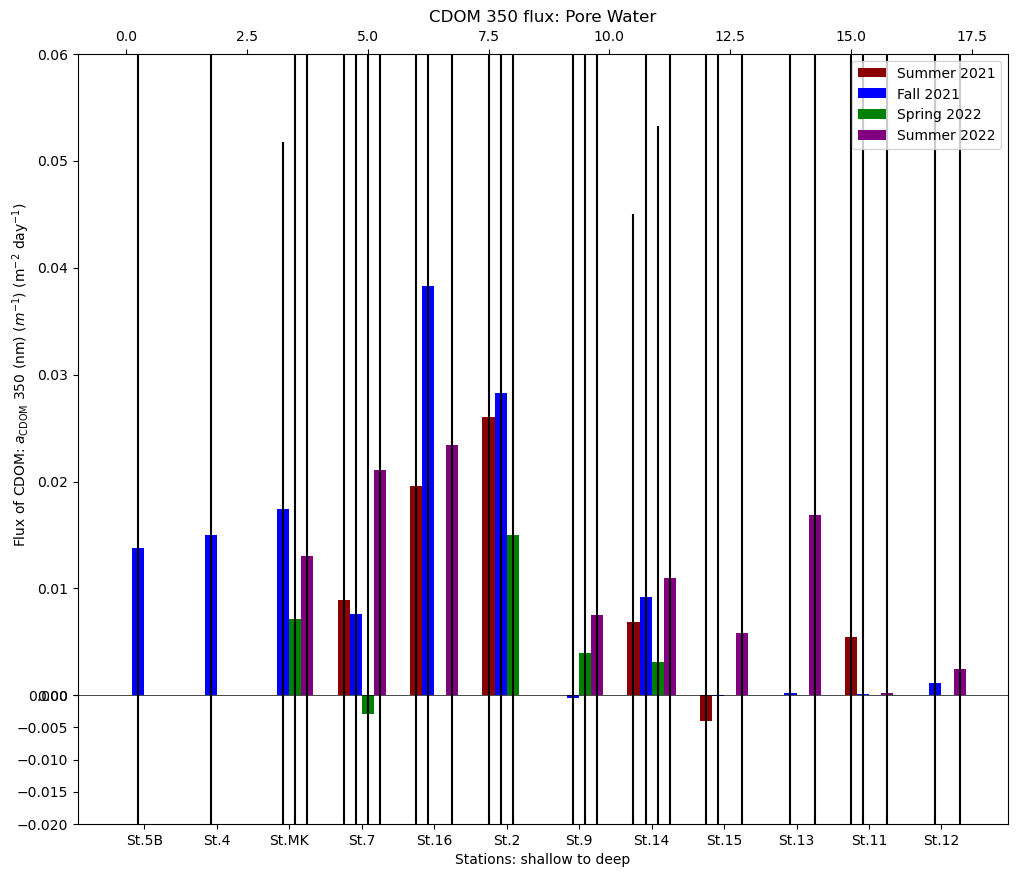

In [23]:
# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_aCDOM350"])

categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

# Create figure with custom size
fig = plt.figure(figsize=(12, 10))
# Adjust the height ratios for the subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0)  # Set hspace to 0

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# Adjusted r for spacing between groups
r = np.arange(0, len(categories) * 1.5, 1.5)
positions = [r + i*barWidth for i in range(len(subcategories))]

# Adjusted code for broken axis and added spaces between the groups
for pos, subcat in zip(positions, subcategories):
    values = []
    errors = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['camp'] == subcat)]['flux_aCDOM350'].values
        error = df[(df['Stn'] == cat) & (df['camp'] == subcat)]['erros_aCDOM350'].values
        values.append(value[0] if len(value) > 0 else 0)
        errors.append(error[0] if len(error) > 0 else 0)
    
    ax1.bar(pos, [v if v > 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat], yerr=[e if e > 0 else 0 for e in errors])
    ax2.bar(pos, [v if v < 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat], yerr=[e if e > 0 else 0 for e in errors])

# Setting the limit for the break
ax1.set_ylim(0, .06)  
ax2.set_ylim(-.02, 0)

# Removing spines and ticks for the broken axis effect
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

# Add some text for labels, title, and custom x-axis tick labels
ax2.set_xlabel('Stations: shallow to deep')
ax1.set_ylabel(r'Flux of CDOM: $a_{\mathrm{CDOM}}$ 350 (nm) $(m^{-1})$ (m$^{-2}$ day$^{-1}$)')
ax1.set_title('CDOM 350 flux: Pore Water')
ax2.set_xticks(r + 1.5*barWidth)  # Adjust for the spaces between groups
ax2.set_xticklabels(categories)

# Add black horizontal line at y=0
ax1.axhline(0, color="black", linewidth=0.5)
ax2.axhline(0, color="black", linewidth=0.5)

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
ax1.legend(handles[:len(subcategories)], labels)

fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/CDOM350_PW_flux_barplot.png")

plt.show()

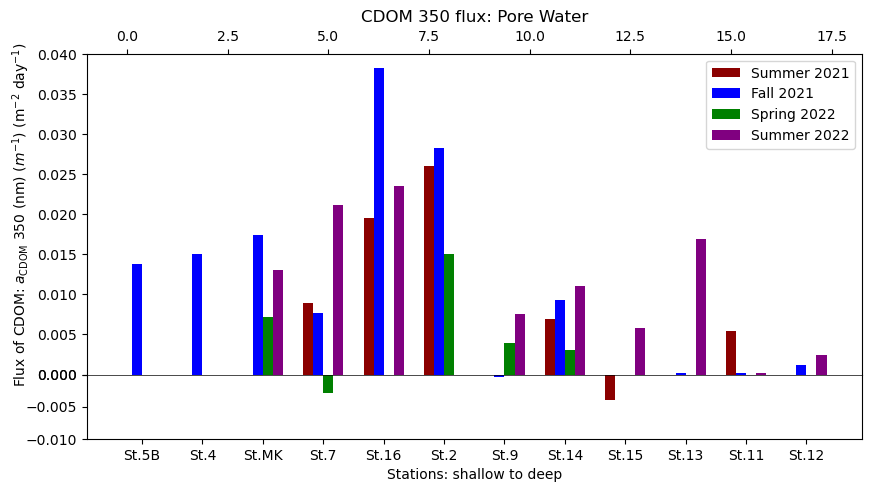

In [24]:
# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_aCDOM350"])

categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

# Create figure with custom size
fig = plt.figure(figsize=(10, 5))
# Adjust the height ratios for the subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0)  # Set hspace to 0

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# Adjusted r for spacing between groups
r = np.arange(0, len(categories) * 1.5, 1.5)
positions = [r + i*barWidth for i in range(len(subcategories))]

# Adjusted code for broken axis and added spaces between the groups
for pos, subcat in zip(positions, subcategories):
    values = []
    errors = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['camp'] == subcat)]['flux_aCDOM350'].values
        error = df[(df['Stn'] == cat) & (df['camp'] == subcat)]['erros_aCDOM350'].values
        values.append(value[0] if len(value) > 0 else 0)
        errors.append(error[0] if len(error) > 0 else 0)
    
    ax1.bar(pos, [v if v > 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat]) #yerr=[e if e > 0 else 0 for e in errors])
    ax2.bar(pos, [v if v < 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat]) #yerr=[e if e > 0 else 0 for e in errors])

# Setting the limit for the break
ax1.set_ylim(0, .04)  
ax2.set_ylim(-.01, 0)

# Removing spines and ticks for the broken axis effect
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

# Add some text for labels, title, and custom x-axis tick labels
ax2.set_xlabel('Stations: shallow to deep')
ax1.set_ylabel(r'Flux of CDOM: $a_{\mathrm{CDOM}}$ 350 (nm) $(m^{-1})$ (m$^{-2}$ day$^{-1}$)')
ax1.set_title('CDOM 350 flux: Pore Water')
ax2.set_xticks(r + 1.5*barWidth)  # Adjust for the spaces between groups
ax2.set_xticklabels(categories)

# Add black horizontal line at y=0
ax1.axhline(0, color="black", linewidth=0.5)
ax2.axhline(0, color="black", linewidth=0.5)

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
ax1.legend(handles[:len(subcategories)], labels)

fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/_CDOM350_PW_flux_barplot.png")

plt.show()

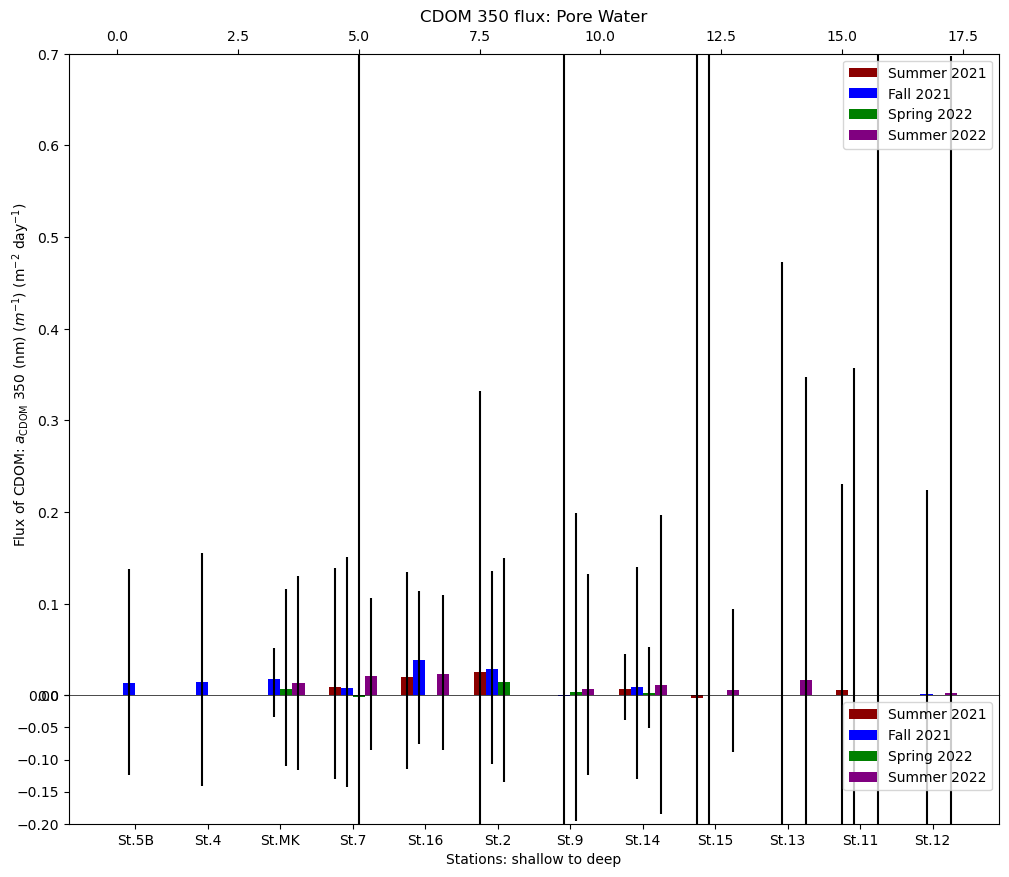

In [25]:
# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_aCDOM350"])

categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

# Create figure with custom size
fig = plt.figure(figsize=(12, 10))
# Adjust the height ratios for the subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0)  # Set hspace to 0

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# Adjusted r for spacing between groups
r = np.arange(0, len(categories) * 1.5, 1.5)
positions = [r + i*barWidth for i in range(len(subcategories))]

# Adjusted code for broken axis and added spaces between the groups
for pos, subcat in zip(positions, subcategories):
    values = []
    errors = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['camp'] == subcat)]['flux_aCDOM350'].values
        error = df[(df['Stn'] == cat) & (df['camp'] == subcat)]['erros_aCDOM350'].values
        values.append(value[0] if len(value) > 0 else 0)
        errors.append(error[0] if len(error) > 0 else 0)
    
    ax1.bar(pos, [v if v > 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat], yerr=[e if e > 0 else 0 for e in errors])
    ax2.bar(pos, [v if v < 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat], yerr=[e if e > 0 else 0 for e in errors])

# Setting the limit for the break
ax1.set_ylim(0, .7)  
ax2.set_ylim(-.2, 0)

# Removing spines and ticks for the broken axis effect
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

# Add some text for labels, title, and custom x-axis tick labels
ax2.set_xlabel('Stations: shallow to deep')
ax1.set_ylabel(r'Flux of CDOM: $a_{\mathrm{CDOM}}$ 350 (nm) $(m^{-1})$ (m$^{-2}$ day$^{-1}$)')
ax1.set_title('CDOM 350 flux: Pore Water')
ax2.set_xticks(r + 1.5*barWidth)  # Adjust for the spaces between groups
ax2.set_xticklabels(categories)

# Add black horizontal line at y=0
ax1.axhline(0, color="black", linewidth=0.5)
ax2.axhline(0, color="black", linewidth=0.5)

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
ax1.legend(handles[:len(subcategories)], labels)

plt.legend()
fig.set_facecolor('w')

#plt.savefig("../Dissertation_projects/Figures/Flux_figures/CDOM350_PW_flux_barplot.png")

plt.show()

# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_aCDOM412"])
df = df[df['rsquared_a412'] >= 0.5]

categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

fig, axs = plt.subplots(figsize=(10, 8)) 

# Set position of bars on x axis
r = np.arange(len(categories))
positions = [r + i*barWidth for i in range(len(subcategories))]

all_bars = []

for pos, subcat in zip(positions, subcategories):
    values = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['camp'] == subcat)]['flux_aCDOM412'].values
        values.append(value[0] if len(value) > 0 else 0)
    bars = plt.bar(pos, values, width=barWidth, color=color_map[subcat], label=label_map[subcat])
    all_bars.append(bars)
    
plt.legend()

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
plt.legend(handles[:len(subcategories)], labels)

# Add some text for labels, title, and custom x-axis tick labels
plt.xlabel('Stations: shallow to deep')
plt.ylabel(r'Flux of CDOM: $a_{\mathrm{CDOM}}$ 412 (nm) $(m^{-1})$ (m$^{-2}$ day$^{-1}$)')
plt.title('CDOM 412 flux: Pore Water')
plt.xticks(r + barWidth, categories)
plt.ylim(-.6,.6)


plt.legend()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/CDOM412_PW_flux_barplot.png")

plt.show()

# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_aCDOM412"])
df = df[df['rsquared_a412'] >= 0.5]

categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

# Create figure with custom size
fig = plt.figure(figsize=(12, 10))
# Adjust the height ratios for the subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0)  # Set hspace to 0

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# Adjusted r for spacing between groups
r = np.arange(0, len(categories) * 1.5, 1.5)
positions = [r + i*barWidth for i in range(len(subcategories))]

# Adjusted code for broken axis and added spaces between the groups
for pos, subcat in zip(positions, subcategories):
    values = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['camp'] == subcat)]['flux_aCDOM350'].values
        values.append(value[0] if len(value) > 0 else 0)
    
    ax1.bar(pos, [v if v > 0 else 0 for v in values], width=barWidth, color=color_map[subcat], label=label_map[subcat])
    ax2.bar(pos, [v if v < 0 else 0 for v in values], width=barWidth, color=color_map[subcat], label=label_map[subcat])

# Setting the limit for the break
ax1.set_ylim(0, .6)  
ax2.set_ylim(-.1, 0)

# Removing spines and ticks for the broken axis effect
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

# Add some text for labels, title, and custom x-axis tick labels
ax2.set_xlabel('Stations: shallow to deep')
ax1.set_ylabel(r'Flux of CDOM: $a_{\mathrm{CDOM}}$ 350 (nm) $(m^{-1})$ (m$^{-2}$ day$^{-1}$)')
ax1.set_title('CDOM 350 flux: Benthic Chamber')
ax2.set_xticks(r + 1.5*barWidth)  # Adjust for the spaces between groups
ax2.set_xticklabels(categories)

# Add black horizontal line at y=0
ax1.axhline(0, color="black", linewidth=0.5)
ax2.axhline(0, color="black", linewidth=0.5)

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
ax1.legend(handles[:len(subcategories)], labels)

plt.legend()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/CDOM412_PW_flux_barplot_scaled.png")

plt.show()

# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_aCDOM350"])
df = df[df['rsquared_a350'] >= 0.5]


categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

fig, axs = plt.subplots(figsize=(10, 8)) 

# Set position of bars on x axis
r = np.arange(len(categories))
positions = [r + i*barWidth for i in range(len(subcategories))]

all_bars = []

for pos, subcat in zip(positions, subcategories):
    values = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['camp'] == subcat)]['flux_aCDOM350'].values
        values.append(value[0] if len(value) > 0 else 0)
    bars = plt.bar(pos, values, width=barWidth, color=color_map[subcat], label=label_map[subcat])
    all_bars.append(bars)
    
plt.legend()

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
plt.legend(handles[:len(subcategories)], labels)

# Add some text for labels, title, and custom x-axis tick labels
plt.xlabel('Stations: shallow to deep')
plt.ylabel(r'Flux of CDOM: $a_{\mathrm{CDOM}}$ 350 (nm) $(m^{-1})$ (m$^{-2}$ day$^{-1}$)')
plt.title('CDOM 350 flux: Pore Water')
plt.xticks(r + barWidth, categories)
plt.ylim(-.1,.2)


plt.legend()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/CDOM350_PW_flux_barplot_scaled.png")

plt.show()

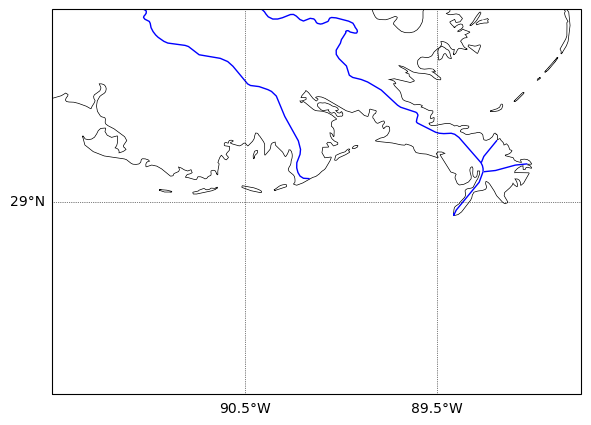

In [26]:
lat_top=30
lat_bot=28
lon_left=-91.5
lon_rigth=-88.75
extent=[lon_left, lon_rigth, lat_bot, lat_top]

# set resolution of the features in map: '10m', '50m', or '110m'.  
# If you do this the first time it will take a while downloading the coastline 
# and other features. In the future it will be faster
res = '10m'

#Figure


def plot_mapbase(extent, res='10m', projection=ccrs.PlateCarree()):
    fig = plt.figure(figsize=(10,5)) # set fig size
    ax = fig.add_subplot(111, projection=projection)
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='white', # change color here
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue', # change color here
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

fig, ax = plot_mapbase(extent)


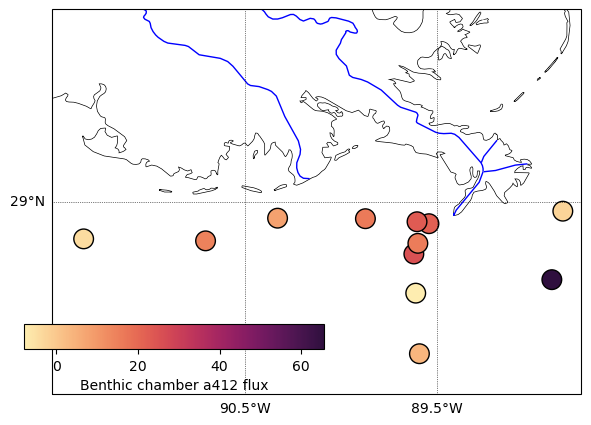

In [27]:
df = df_flux.dropna(subset=["flux_doc"])
df = df[df['camp'] == 'GOM21FA']

fig, ax = plot_mapbase(extent)
mappable = ax.scatter(df['Lon'], df['Lat'],
                      c = df['flux_doc'],           
                      edgecolor='k',  #you color variable
                      cmap= cmo.matter, # colormap. look for other colormaps https://matplotlib.org/stable/tutorials/colors/colormaps.html
                      s=200, # your size variable. Can get rid if don't need
                      transform=ccrs.PlateCarree())
cax = fig.add_axes([.22, .2, .3, .05])
cb2 = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb2.set_label('Benthic chamber a412 flux', size=10, color='black')
cb2.ax.tick_params(labelcolor='black') 
cb2.ax.tick_params(labelsize=10)

fig.set_facecolor('w')



#fig.savefig('../MAPS_Figures/BC_flux_412.png')

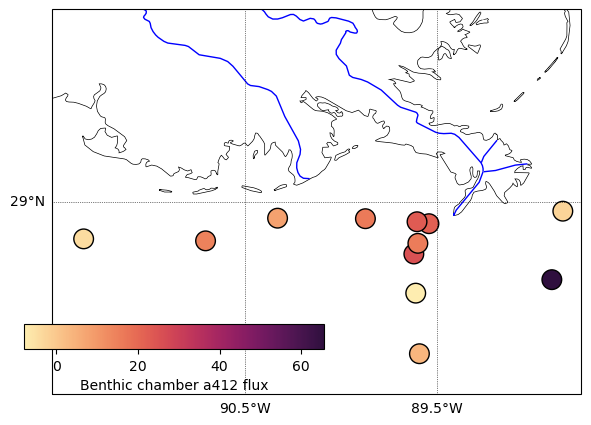

In [28]:
df = df_flux.dropna(subset=["flux_doc"])
df = df[df['camp'] == 'GOM21FA']

fig, ax = plot_mapbase(extent)
mappable = ax.scatter(df['Lon'], df['Lat'],
                      c = df['flux_doc'],           
                      edgecolor='k',  #you color variable
                      cmap= cmo.matter, # colormap. look for other colormaps https://matplotlib.org/stable/tutorials/colors/colormaps.html
                      s=200, # your size variable. Can get rid if don't need
                      transform=ccrs.PlateCarree())
cax = fig.add_axes([.22, .2, .3, .05])
cb2 = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb2.set_label('Benthic chamber a412 flux', size=10, color='black')
cb2.ax.tick_params(labelcolor='black') 
cb2.ax.tick_params(labelsize=10)

fig.set_facecolor('w')

In [29]:
def plot_mapbase(extent, ax=None, res='10m', projection=ccrs.PlateCarree()):
    if ax is None:
        fig = plt.figure(figsize=(10,5)) # set fig size
        ax = fig.add_subplot(111, projection=projection)
        
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='white', 
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue',
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax


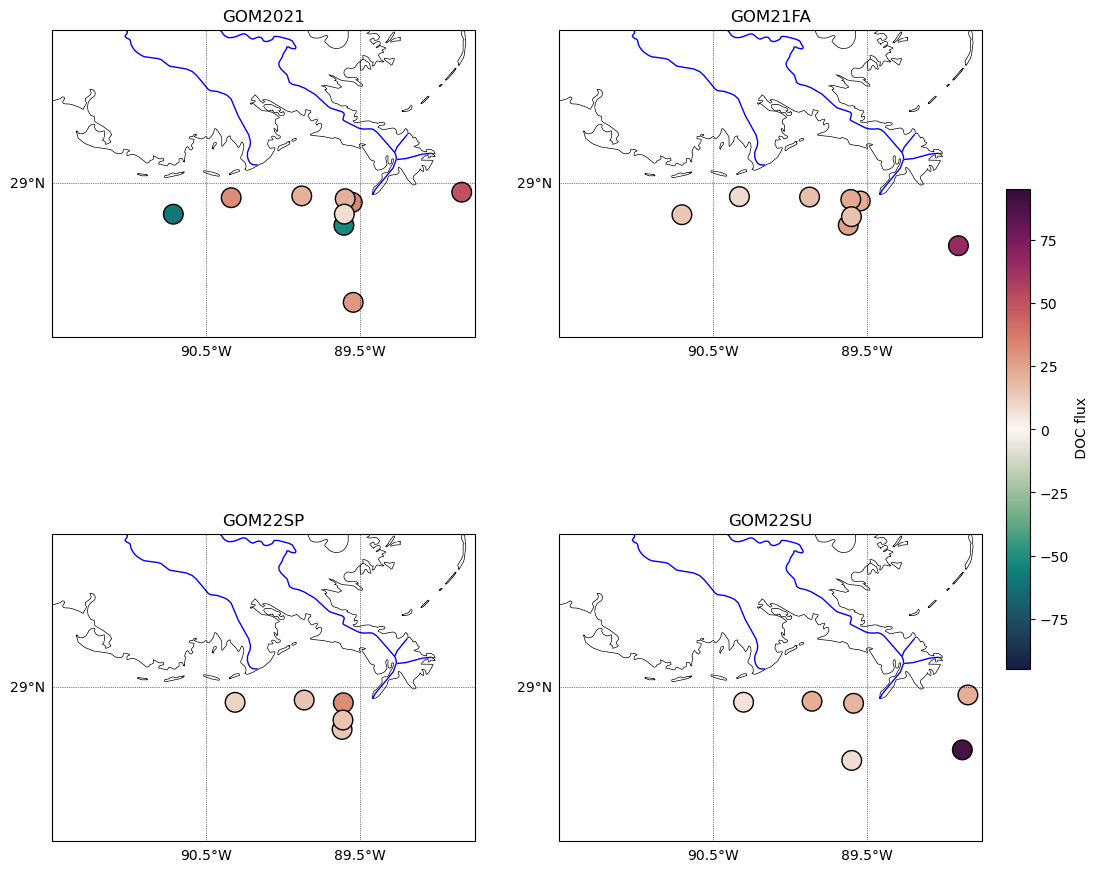

In [30]:
# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Find global min and max for the colormap
vmin = -95
vmax = 95

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index

for i, camp in enumerate(camps):
    df_subset = df_flux[df_flux['camp'] == camp].dropna(subset=["flux_doc"])
    df_subset = df_subset[df_subset['rsquared_doc'] >= 0.2]
    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['Lon'], df_subset['Lat'],
                               c=df_subset['flux_doc'],
                               edgecolor='k',
                               cmap=cmo.curl,
                               s=200,
                               vmin=vmin,  # Set global min and max for colormap
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label(' DOC flux', size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/Map_PW_DOC_Flux.png")

plt.show()


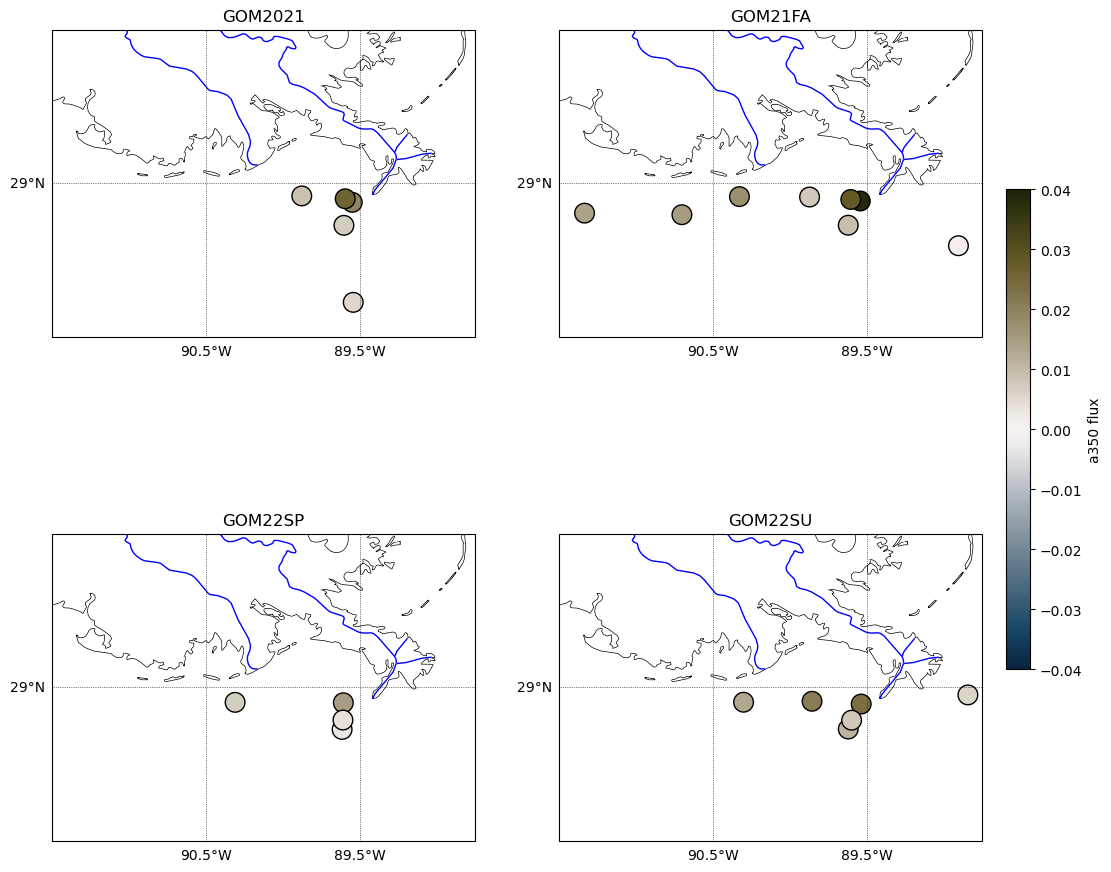

In [31]:
# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Find global min and max for the colormap
vmin = -.04
vmax = .04

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index

for i, camp in enumerate(camps):
    df_subset = df_flux[df_flux['camp'] == camp].dropna(subset=["flux_aCDOM350"])
    df_subset = df_subset[df_subset['rsquared_a350'] >= 0.5]
    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['Lon'], df_subset['Lat'],
                               c=df_subset['flux_aCDOM350'],
                               edgecolor='k',
                               cmap=cmo.diff,
                               s=200,
                               vmin=vmin,  # Set global min and max for colormap
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label('a350 flux', size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/Map_PW_CDOM350_Flux.png")

plt.show()


# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Find global min and max for the colormap
vmin = -.02
vmax = .02

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index

for i, camp in enumerate(camps):
    df_subset = df_flux[df_flux['camp'] == camp].dropna(subset=["flux_aCDOM412"])
    df_subset = df_subset[df_subset['rsquared_a412'] >= 0.5]

    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['Lon'], df_subset['Lat'],
                               c=df_subset['flux_aCDOM412'],
                               edgecolor='k',
                               cmap=cmo.diff,
                               s=200,
                               vmin=vmin,  # Set global min and max for colormap
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label('a412 flux', size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

plt.title(r'CDOM 412 flux:'+'\n'+' Pore Water'+'\n')

fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/Map_PW_CDOM412_Flux.png")

plt.show()


# Define the camps and flux types
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']
flux_types = ['flux_aCDOM350', 'flux_doc', 'flux_aCDOM412']

# Create a 3x4 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})

for row, flux_type in enumerate(flux_types):
    # Determine the global min and max for the current flux type across all camps
    vmin = df_flux[df_flux['camp'].isin(camps)][flux_type].min()
    vmax = df_flux[df_flux['camp'].isin(camps)][flux_type].max()
    
    for col, camp in enumerate(camps):
        df_subset = df_flux[df_flux['camp'] == camp].dropna(subset=[flux_type])
        
        mappable = axes[row, col].scatter(df_subset['Lon'], df_subset['Lat'],
                                          c=df_subset[flux_type],
                                          edgecolor='k',
                                          cmap=cmo.matter,
                                          s=100,
                                          vmin=vmin,
                                          vmax=vmax,
                                          transform=ccrs.PlateCarree())
        
        axes[row, col].set_title(f'{camp} - {flux_type}')
        
        plot_mapbase(extent, ax=axes[row, col])

    # Add a colorbar for each row (flux type)
    cbar_ax = fig.add_axes([0.92, 1-(0.29*(row+1)), 0.015, 0.125])
    cb = fig.colorbar(mappable, cax=cbar_ax)
    cb.set_label(flux_type, size=10, color='black')
    cb.ax.tick_params(labelcolor='black') 
    cb.ax.tick_params(labelsize=10)

fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/Maps_PW_Flux.png")

plt.show()
